In [1]:
!pip install spacy
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 7.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=6e996fae7c5a0dfda007f0fa3f2adf6bd98102e2cc06b623cecb3a4153e89cad
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=5b2bc741f9df9661a6ee096f605b654111b7f384d3fd5f2351375ce24430028e
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built pyLDAvis sklearn


In [ ]:
!python3 -m spacy download en_core_web_sm

In [12]:
import re
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

import seaborn as sns

import spacy
import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [38]:
data_full = pd.read_csv('depression.csv', error_bad_lines=False);
data_full.head(5)
print(data_full.shape)

(892, 9)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [39]:
stop_words = stopwords.words('english')
stop_words.extend(['like', "i'm", "don't",'would',"can't",'want',"even","it's","it","me.","i've","it.","going","'ve", "n't"
                   ])

In [40]:
data_full.head(5)

,Unnamed: 0,id,subreddit,title,text,upvote_ratio,ups,downs,score
0,0,t3_yqquwg,depression,😐,I'm starting to hate my life. I started my cyc...,1.0,6.0,0.0,6.0
1,1,t3_yqqpvd,depression,Would you lie and say that you had a good time...,Would you lie that you enjoyed an activity jus...,1.0,2.0,0.0,2.0
2,2,t3_yqqnxe,depression,So fucking stupid,"I feel like shit rn, but the fact that I know ...",1.0,1.0,0.0,1.0
3,3,t3_yqqlij,depression,Getting harder every day man,Keep getting more anxious by the night. Becaus...,1.0,12.0,0.0,12.0
4,4,t3_yqq8ay,depression,Am I ever going to get one ok year ever again?,"My grandma died last year, my grandpa this yea...",1.0,2.0,0.0,2.0


In [41]:
def freq_words(x, terms = 30):
  
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  d = words_df.nlargest(columns="count", n = terms) 
  
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

In [42]:
# import string

# nltk.download('stopwords')
# from nltk.corpus import stopwords
# remove_these = set(stopwords.words('english') + list(string.punctuation) + list(string.digits))

# filtered_text = data['text'].apply(lambda x: ' '.join([w for w in x.split() if not w in remove_these and len(w)>2]))
# all_words = ' '.join([text for text in filtered_text])
# all_words = all_words.split()
# fdist_filtered = FreqDist(all_words)
# fdist_filtered.plot(30,title='Frequency distribution for 30 most common tokens')


In [43]:
df=data_full

In [44]:
df["concatenated_review"] = df['title'] +" " + df['text']

# df["concatenated_review"] = df['title']



In [45]:
def clean_text(text):
      word_tokens=word_tokenize(text)
      tokens=[w for w in word_tokens if (w not in stop_words) and (not w.isnumeric()) and (len(w)>2) ]
      cleaned_text=" ".join(tokens)
      return cleaned_text
df['concatenated_review']=df['concatenated_review'].apply(clean_text)

In [46]:
df['concatenated_review']

0      starting hate life started cycle mom process b...
1      Would lie say good time Would lie enjoyed acti...
2      fucking stupid feel shit fact know eventually ...
3      Getting harder every day man Keep getting anxi...
4      ever get one year ever grandma died last year ...
                             ...                        
887    friends keep leaving dark This first ever post...
888    adult drive work NEET lost dark hell pit way n...
889    Life Painful All Aspects Feel Alone really wri...
890    Daylight savings time depression hate gets dar...
891    know feel Recently lot stress strained relatio...
Name: concatenated_review, Length: 892, dtype: object

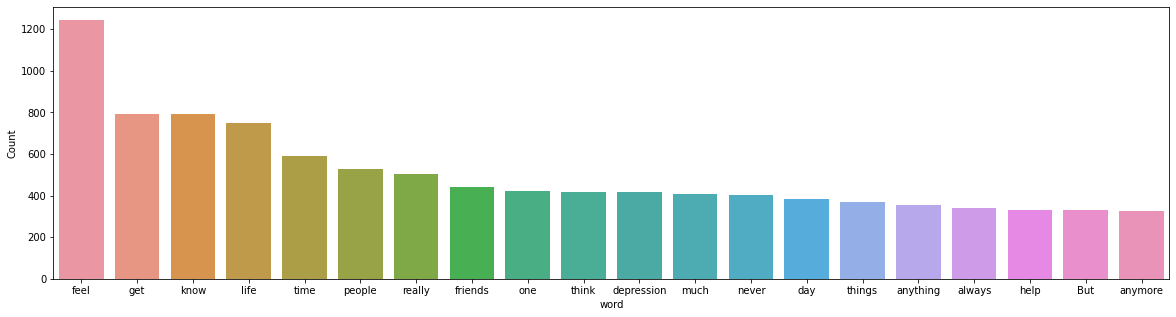

In [47]:
freq_words(df['concatenated_review'],20)

In [48]:
data = df['concatenated_review']

In [49]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

data_words = list(sent_to_words(data))

print(data_words[:1])

[['starting', 'hate', 'life', 'started', 'cycle', 'mom', 'process', 'braiding', 'hair', 'wear', 'scarf', 'cover', 'rest', 'wonder', 'could', 'really', 'make', 'friends', 'college', 'pain', 'school', 'overstimulated', 'cried', 'little', 'this', 'day', 'sucks', 'wait', 'home']]


In [50]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) 
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def lemmatization(texts, allowed_postags=['NOUN']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [51]:
data_words_bigrams = make_bigrams(data_words)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])

print(data_lemmatized[:1])

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


[['hate', 'life', 'cycle', 'mom', 'process', 'hair', 'cover', 'rest', 'wonder', 'friend', 'college', 'pain', 'school', 'overstimulated', 'day', 'home']]


## LDA

In [52]:
id2word = corpora.Dictionary(data_lemmatized)
id2word.filter_extremes(no_below=5, no_above=0.9)
texts = data_lemmatized

corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]]


In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [54]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.038*"disorder" + 0.033*"thought" + 0.031*"love" + 0.030*"death" + 0.029*"birthday" + 0.023*"amount" + 0.021*"hope" + 0.020*"joy" + 0.018*"joke" + 0.018*"heart"
Topic: 1 
Words: 0.102*"depression" + 0.100*"day" + 0.042*"anxiety" + 0.040*"month" + 0.039*"help" + 0.035*"week" + 0.020*"issue" + 0.019*"today" + 0.017*"bed" + 0.016*"medication"
Topic: 2 
Words: 0.117*"parent" + 0.077*"mom" + 0.028*"brother" + 0.026*"mother" + 0.025*"job" + 0.023*"sister" + 0.022*"boyfriend" + 0.020*"problem" + 0.018*"money" + 0.017*"teacher"
Topic: 3 
Words: 0.068*"year" + 0.036*"life" + 0.035*"work" + 0.020*"school" + 0.020*"hate" + 0.020*"class" + 0.018*"college" + 0.018*"time" + 0.014*"care" + 0.014*"body"
Topic: 4 
Words: 0.060*"life" + 0.057*"people" + 0.054*"thing" + 0.050*"time" + 0.049*"friend" + 0.021*"family" + 0.015*"talk" + 0.014*"person" + 0.014*"feel" + 0.013*"way"


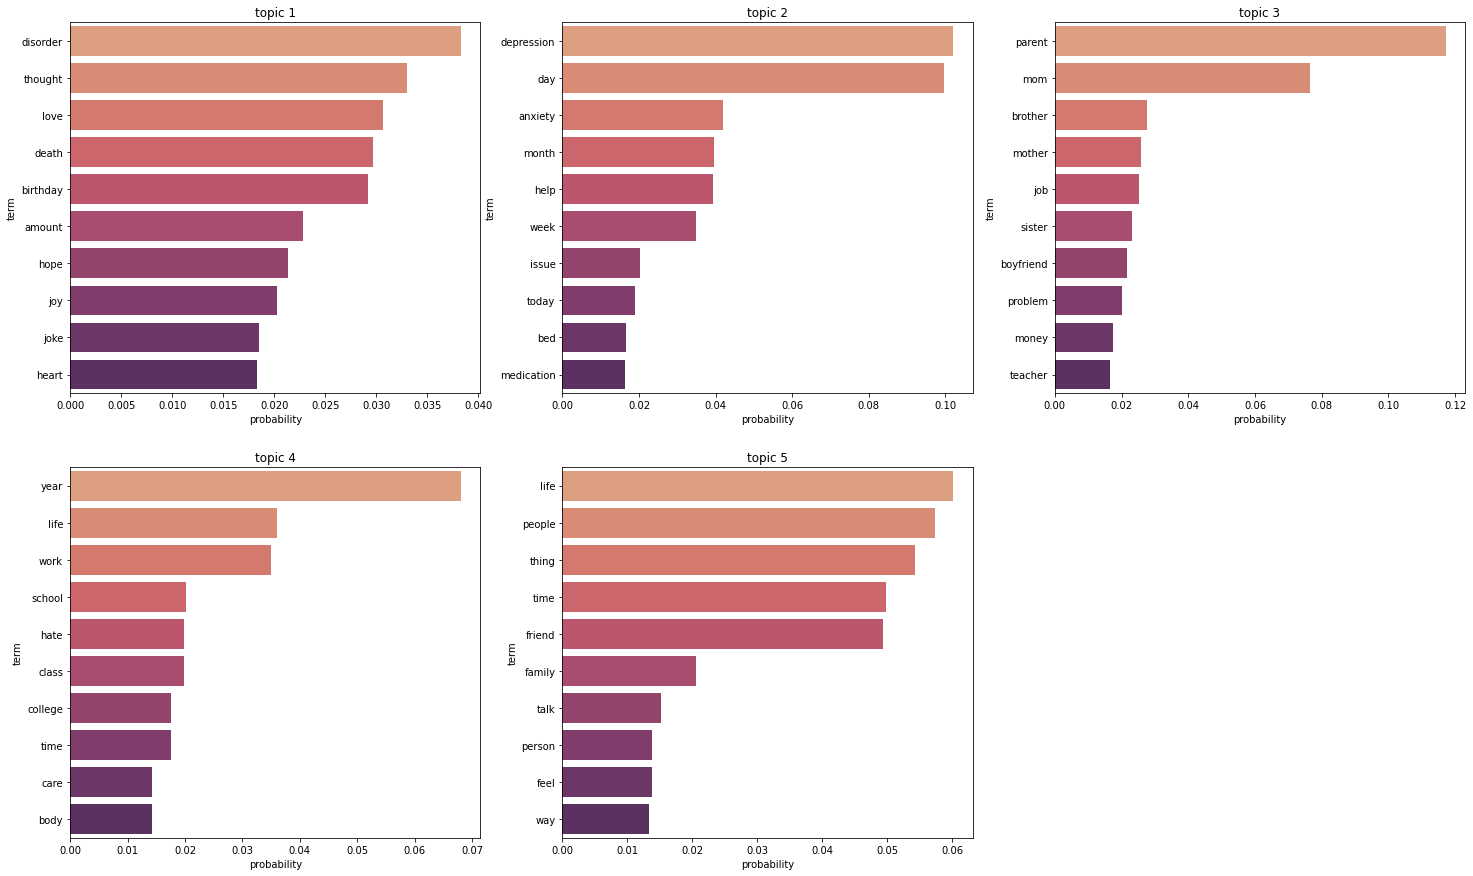

In [57]:
fiz=plt.figure(figsize=(25,15))
for i in range(5):
    df=pd.DataFrame(lda_model.show_topic(i), columns=['term','prob']).set_index('term')
    # df=df.sort_values('prob')
    
    plt.subplot(2,3,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, label='terms', palette='flare')
    plt.xlabel('probability')
    

plt.show()

In [58]:
# import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word,sort_topics=False)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.222748  0.297179       1        1   5.169299
1      0.193214  0.026432       2        1  18.631311
2     -0.251209 -0.272553       3        1   8.102527
3      0.151938 -0.034667       4        1  24.677873
4      0.128805 -0.016392       5        1  43.418990, topic_info=           Term        Freq       Total Category  logprob  loglift
75   depression  424.000000  424.000000  Default  30.0000  30.0000
2           day  509.000000  509.000000  Default  29.0000  29.0000
192      parent  225.000000  225.000000  Default  28.0000  28.0000
8           mom  139.000000  139.000000  Default  27.0000  27.0000
57         year  461.000000  461.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
23        point  106.385219  174.238270   Topic5  -4.5108   0.3409
55          way  128.976859  247.796981   Topic5  -4.3182   0.1813
121         job  125.732019  244.361070   Topic5  -4.3437   0.1698
2           day   73.482218  509.088173   Topic5  -4.8808  -1.1013
9          pain   63.119551   94.771904   Topic5  -5.0328   0.4278

[261 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
621       3  0.952330      abuse
621       4  0.043288      abuse
254       2  0.958345  addiction
255       2  0.967423       adhd
86        2  0.985599     advice
...     ...       ...        ...
57        2  0.069268       year
57        3  0.008658       year
57        4  0.809568       year
57        5  0.112560       year
452       5  0.971016  yesterday

[342 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [59]:
pyLDAvis.save_html(vis, 'depression_topic_modeling.html')


## BERT

In [ ]:
!pip install BERTopic

In [61]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

text = data

model = BERTopic(
    vectorizer_model=vectorizer_model,
    language='english', calculate_probabilities=True,
    verbose=True
)
topics, probs = model.fit_transform(text)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

2022-11-15 02:20:54,857 - BERTopic - Transformed documents to Embeddings
2022-11-15 02:21:07,284 - BERTopic - Reduced dimensionality
2022-11-15 02:21:07,379 - BERTopic - Clustered reduced embeddings


In [62]:
freq = model.get_topic_info()
freq.head(10)

,Topic,Count,Name
0,-1,484,-1_feel_know_life_people
1,0,46,0_feel_life_time_know
2,1,43,1_suicidal_suicide_thoughts_suicidal thoughts
3,2,38,2_life_people_job_better
4,3,37,3_feel_depression_day_feeling
5,4,36,4_depression_feel_people_know
6,5,33,5_feel_feeling_know_human
7,6,29,6_friends_friend_really_feel
8,7,22,7_depression_tried_meds_struggling
9,8,18,8_college_semester_classes_parents


In [63]:
model.visualize_topics()


In [64]:
model.visualize_hierarchy()


/usr/local/lib/python3.7/dist-packages/plotly/figure_factory/_dendrogram.py:350: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/usr/local/lib/python3.7/dist-packages/plotly/figure_factory/_dendrogram.py:351: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/usr/local/lib/python3.7/dist-packages/plotly/figure_factory/_dendrogram.py:352: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/usr/local/lib/python3.7/dist-packages/plotly/figure_factory/_dendrogram.py:353: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead



In [65]:
model.visualize_barchart()


In [67]:
model.visualize_distribution(probs[1])

In [68]:
model.visualize_distribution(probs[2])